## ANOVA, linear regression and general linear model



In [18]:

# Import data & Libraries

from scipy.stats import *
from scipy.stats import ttest_rel,ttest_1samp,ttest_ind
from scipy.stats import circmean,circvar
from scipy.stats import binned_statistic
from scipy.stats import spearmanr as spear
from scipy.stats.mstats import zscore
from scipy.io import loadmat
from scipy import stats
from numpy import *
import numpy as np
from  numpy import array
from matplotlib.pylab import *
from matplotlib.mlab import *
import matplotlib.pyplot as plt
import pandas
from pandas.core import datetools
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import *
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from math import atan2
import sys
from pickle import dump,load
from cmath import phase,polar
import random
import scikits.bootstrap as bootstrap

% matplotlib inline


f = open("all_subjs.mat", "rb")
all_subjs = loadmat(f)["all_subjs"]
all_subjs = [subj[0] for subj in all_subjs]    



In [2]:
#Functions

leters = "ABDEFGHIJKLMNOPQRSTUVXZ"
jbtest = jarque_bera 

def anovan(y,data,names=leters):
    n_groups = range(len(data[0]))
    model = "y ~ "
    d_data = {}
# import ipdb; ipdb.set_trace()
    d_data["y"] = y
    for g in n_groups:
        model += "C("+names[g]+")*"
        d_data[names[g]] = data[:,g]
    lm = ols(model[:-1], data=pandas.DataFrame(d_data)).fit()
    table = anova_lm(lm)
    resid = lm.resid
    return (table,resid)
#return model,pandas.DataFrame(d_data

def anovan1(y,data,names=leters):
    model = "y ~ "
    d_data = {}
    d_data["y"] = y
    d_data[leters[0]] = data
    lm = ols("y~C("+leters[0]+")", data=pandas.DataFrame(d_data)).fit()
    table = anova_lm(lm)
    resid = lm.resid
    return (table,resid)

def regress(y,data,names=leters):
    n_groups = range(len(data[0]))
    model = "y ~ "
    d_data = {}
    d_data["y"] = y
    for g in n_groups:
        model += names[g]+"+"
        d_data[names[g]] = data[:,g]
    lm = ols(model[:-1], data=pandas.DataFrame(d_data)).fit()
    ci = lm.conf_int()
    params = [lm.params[p] for p in range(len(data[0]))]
    return (params,lm.resid,ci)

def glmfit(y,data):
    n_groups = range(len(data[0]))
    model = "y ~ "
    d_data = {}
# import ipdb; ipdb.set_trace()
    d_data["y"] = y
    for g in n_groups:
        model += ""+leters[g]+"+"
        d_data[leters[g]] = data[:,g]
    lm = ols(model[:-1], data=pandas.DataFrame(d_data)).fit()
    ci = m.conf_int()
    return lm

def nans(shape, dtype=float):
    a = empty(shape, dtype)
    a.fill(nan)
    return a



def convert_2pi(angle):
    if angle < 0:
        angle = angle + 2*pi
    return angle

    if angle > pi:
        angle = angle - 2*pi
    return angle


def len2(x):
    if type(x) is not type([]):
        if type(x) is not type(array([])):
            return -1
    return len(x)

def phase2(x):
    if not isnan(x):
        return phase(x)
    return nan

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
    if len2(angles1) < 0:
        angles1 = [angles1]*len(angles2)
    return amap(lambda a1,a2: phase2(exp(1j*a1)/exp(1j*a2)), angles1,angles2)


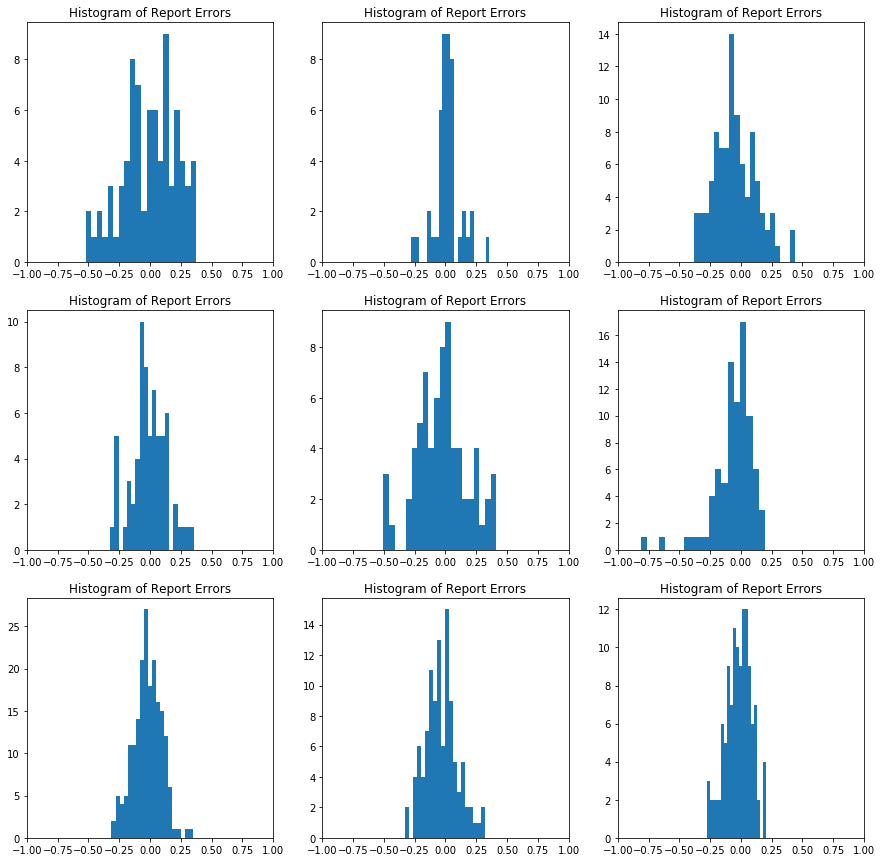

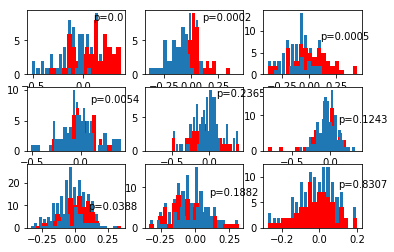

In [3]:
# Load the Psychophysics data (Experiment 2) as in Assignment 4.

dist_nt=[]
err=[]
for i in range(0,9):
    dist_nt.append(circdist(all_subjs[i][:,2],all_subjs[i][:,1]))
    err.append(circdist(all_subjs[i][:,0],all_subjs[i][:,1]))
    
plt.figure(figsize=(15,15))

for i in range(0,9):
    plt.subplot(3,3,i+1)
    plt.hist(err[i],bins=20)
    plt.xlim(-1,1)
    plt.title('Histogram of Report Errors')
plt.show()

for i in range(0,9):
    inCW=np.where(dist_nt[i]<0) # clockwise
    inCCW=np.where(dist_nt[i]>0) #counter clockwise
    

    hist, bins = np.histogram(err[i], bins=20)
    H=plt.hist(err[i][inCW],bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(3,3,i+1)
    plt.bar(center, hist, align='center', width=width)
    H=plt.hist(err[i][inCCW],bins=bins, color='r')
    width = 0.7 * (bins[1] - bins[0])
    alpha=.5
    [h,pval]=stats.ttest_ind(err[i][inCW], err[i][inCCW])
    text(.1,8,'p=' + str(round(pval,4)))

 
plt.figure(figsize=(20,20))    
plt.show()

### Class Notes

Using ANOVA:  when we have more than 2 variables to compare or more than 2 groups to compare.

The difference between ANOVA and regression analysis;
-anova cares about two groups and compares means. (categorical)
-regression cares about the measurements and sees whether they predict each other. (not categorical)

T-Test and ANOVA are similar but the categories and levels to compare are different.

### Exercise 1

We want to test if there is any effect at the population level of the nearest non-target (NT) item (column 3) on the bias of the behavioral response. The simplest way to test this is by using a t-test to compare the behavioral errors (response (R) - target (T)) for trials in which the NT was clockwise to the T stimulus (CW trials, NT-T<0) with the behavioral errors for trials in which the NT was counterclockwise to the T stimulus (CCW trials, NT-T>0), lumping together data from all subjects. Take a look at Figure 1 to remember the logic of CW and CCW trials. In order to do this, run through all your subjects in all_subjs and accumulate all behavioral errors (R-T) in one long vector/list Y. At the same time, compute the difference between the target and nearest non-target item angles and accumulate them in another long list X.

Hint: The difference in angles is best computed with circ_dist. This function receives two lists of radians. 

Notice that the sign of values in Y and X indicate the sense (clockwise vs. counterclockwise) of the behavioral errors or distance to the NT item, respectively. We can thus select CW or CCW trials sign of X, and thus build two different lists, Y_CW and Y_CCW, with the values of Y in each of these two sets of trials. We now can simply compute a 2-sample t-test (Matlab: ttest2, Python: ttest_ind) to test the null hypothesis that these two lists of errors come from the same underlying distribution (i.e. there is no effect of NT item location on behavioral error). Alternatively, we could run a non-parametric test with a permutation test or a Wilcoxon rank test (don’t do it now, though).



In [4]:
X= np.array([]) # X is the difference between target and non-target.
Y= np.array([]) # Y is the difference between response and targets, for each subject, you add the values to the end of the list. It is also a long vector.

for i in range(0,9): #using circ_dist to compute difference between angles
    y= circdist(all_subjs[i][:,0], all_subjs[i][:,1]) #y for subject i
    x= circdist(all_subjs[i][:,2], all_subjs[i][:,1]) #x for subject i
    Y= np.concatenate([Y,y])
    X= np.concatenate([X,x]) # puts x/y value under the previous X/Y vector 

print (len(X)) #857 rows 
print (len(Y))


inCW_Y = Y[np.where(X <0)] #clockwise behavioural errors or distance to the NT item
inCCW_Y = Y[np.where(X >0)] #counterclockwise behavioural errors or distance to the NT item

#two sample t-test
[h,pval]=stats.ttest_ind(inCW_Y, inCCW_Y) # to test the null hypothesis that these two lists of errors come from the same underlying distribution
print (pval) #which is 0.00013054065806483438 and p<0,05 which means there is an effect



857
857
0.00013054065806483438


### Exercise 2

The result shows a significant effect. However, the test did not take into account all we know about these data. In particular, we lumped together measurements that we obtained from different subjects so we were not satisfying the conditions of independence for all our points in Y. A better solution is to enter the factor “subject” in our analysis, and for this we can use an ANOVA test. Copy your code from Exercise 1, and now create one more list S accumulating the subject number that each trial corresponded to. In this way, we create a “design matrix”:

Matlab: M=[sign(X) S]; 

With the two factors in our analysis: clockwise/counterclockwise trials, and subject. You can visualize this matrix with the command imagesc/imshow. Can you interpret this figure? 

Now you can run the anova test using the anovan command. First, we will run anovan with just one factor (trial type, either CW or CCW). This is what we call a one-way ANOVA. What P-value do you get? Is it larger or smaller than the t-test in Exercise 1? What do you learn from this? What is then the difference between a one-way ANOVA and a t-test? 

Now let’s run the ANOVA test with two factors (trial type and subject), this is a two-way ANOVA.  The test now gives two p-values, one for each factor. Interpret them. Was it worth adding the factor subject? Why?
This test now confirms that there is a significant difference in behavioral error for CW and CCW trials. Compute the marginal mean of Y for CW and CCW trials to interpret the sense of the effect, and convince yourself that there is an attraction of behavioral responses towards nearby non-target items.


857
120
0.00013054065806481852
14.768612226508337
(857L,)
(857L,)


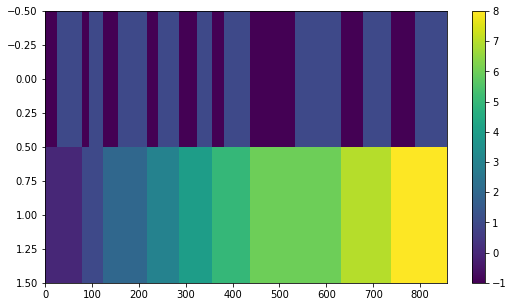

                             df     sum_sq   mean_sq          F        PR(>F)
C(Nontarget)                1.0   0.329025  0.329025  16.117318  6.486729e-05
C(Subjects)                 8.0   0.296002  0.037000   1.812457  7.129105e-02
C(Nontarget):C(Subjects)    8.0   1.624598  0.203075   9.947631  2.708480e-13
Residual                  839.0  17.127672  0.020414        NaN           NaN


In [40]:
S = [] # the list for accumulating the subject number that each trial corresponded to.
M = np.sign(X) # Turned X into two categories: negative and positive

for i in range(len(all_subjs)):
    ntrials=len(all_subjs[i][:,0]) 
    s=np.ones((ntrials,1),dtype=int)*i
    S.append(s)
S=np.concatenate((S[0],S[1],S[2],S[3],S[4],S[5],S[6],S[7],S[8]),axis=0)


print (len(S))# S is 857
print (len(s)) #ntrials is 120

#one-way ANOVA 
[F,P] = stats.f_oneway(inCW_Y,inCCW_Y)
print (P)
print (F)
#according to one-way ANOVA result, there is a still significant effect. But I can't understand the clear difference between t-test and ANOVA.
len(Y)
len(M)
print shape(M)
print shape(Y)

#Let's make two-way ANOVA to understand see a clear difference
M=np.array((sign(X),S[:,0])) #first we should create a design matrix
plt.figure(figsize=(9,5))
plt.imshow(M,aspect='auto')
plt.colorbar() #we can see the layers of our data in our data
plt.show()

M=M.T
[P,T]=anovan(Y,M,['Nontarget','Subjects'])
print (P)
# the values that I get is slightly different than the matlab code in the class. But, P value is different now. 
#according to the table there is no significant difference between subjects.



### Exercise 3

In the previous analysis, we did not worry about the assumptions of our test. ANOVA is a parametric test and assumes a normal distribution of residual errors. Find how to get the list of residuals from anovan, and then take a look at how they are distributed (use qqplot to get a plot that directly compares with a normal distribution). To assess statistically whether a list of numbers is consistent with a normal distribution, you can use the Jarque-Bera test jbtest. When we find a violation of the assumptions, we should not panic. One thing to look at is outliers. Are there points in the data Y beyond 3 standard deviations? What happens to your ANOVA test when you remove those data from Y? Do the results change? If they do not, you can trust your test. If they do, outliers are important and you can try to transform the data to keep them in the analysis but achieve Gaussian statistics.

Hint: to detect outliers based on the number of standard deviations from the mean, you can use the command zscore. It provides, for each data point, its distance to the sample’s mean in units of the sample’s standard deviation.



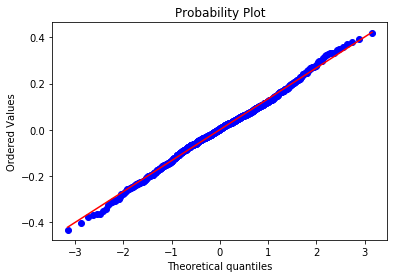

                             df     sum_sq   mean_sq          F        PR(>F)
C(Nontarget)                1.0   0.301281  0.301281  14.741667  1.326798e-04
C(Subjects)                 8.0   0.311809  0.038976   1.907100  5.587352e-02
C(Nontarget):C(Subjects)    8.0   1.646263  0.205783  10.068960  1.828031e-13
Residual                  829.0  16.942568  0.020437        NaN           NaN


In [50]:
# Use qqplot to compare with a normal distribution
import scipy.stats as stats 
stats.probplot(T, plot=plt) # T is similar to resid. 
plt.show()

stats.jarque_bera(T) # it is again different than the matlab code. I'm not sure if it is correct and which part I'm missing.
#To assess statistically whether a list of numbers is consistent with a normal distribution
good=find(abs(zscore(T))<3)#Are there points in the data Y beyond 3 standard deviations?
len(good)

[P,T]=anovan(Y[good],M[good,:],['Nontarget','Subjects'])

print (P) #there is no significant difference between subjects. 